In [198]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import sys
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from typing import Union, Tuple
from torch.utils.data import Dataset, DataLoader
import cv2

In [199]:
from google.colab import drive
#drive.mount('/content/drive')

In [200]:
train_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

In [201]:
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
mean, std

(tensor(0.1307), tensor(0.3081))

In [202]:
transform  = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
])

train_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

In [203]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Exercise 2
Now that you have built an Autoencoder, it is time to implement a Variational Autoencoder.
You can use the Autoencoder you trained in the previous exercise and adapt it for this
exercise. Do not forget to use the reparametrization trick for sampling from Z-space.

In [204]:

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super(Unflatten, self).__init__()
        self.channel = channel
        self.height = height
        self.width = width

    def forward(self, input):
        return input.view(input.size(0), self.channel, self.height, self.width)


class ConvVAE(nn.Module):

    def __init__(self, latent_size):
        super(ConvVAE, self).__init__()

        self.latent_size = latent_size
        #encoder
        self.encoder = nn.Sequential(
            OrderedDict([
            ('conv1',nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)),
            ('relu1',nn.ReLU()),
            ('conv2',nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            ('relu2',nn.ReLU()),
            ('flatten',Flatten()), #flatten 
            ('fc1',nn.Linear(6272, 1024)),
            ('relu3',nn.ReLU())
            ])) 
        #latent space 
        # hidden => mu
        self.fc1 = nn.Linear(1024, self.latent_size)

        # hidden => logvar
        self.fc2 = nn.Linear(1024, self.latent_size)
        #decoder
        self.decoder = nn.Sequential(
            OrderedDict([
            ('fc1',nn.Linear(self.latent_size, 1024)),
            ('relu1',nn.ReLU()),
            ('fc2',nn.Linear(1024, 6272)),
            ('relu2',nn.ReLU()),
            ('unflatten',Unflatten(128, 7, 7)),
            ('relu3',nn.ReLU()),
            ('convT1',nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)),
            ('relu4',nn.ReLU()),
            ('convT2',nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)),
            ('sigmoid',nn.Sigmoid())
            ]))

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar


In [205]:
model = ConvVAE(latent_size=2).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [206]:
def kld(mu, sigma):
  #return 0.01*0.5*torch.sum(mu**2 + sigma**2-1-torch.log(sigma**2))
  beta=3
  return beta*0.5*torch.sum(mu**2 + sigma**2-1-torch.log(sigma**2))

In [207]:
def train(model: nn.Module,  optimizer: optim.Optimizer,  data: train_loader, max_epochs: int, cuda=True):
  total_loss = []
  for epoch in range(max_epochs):
      for batch in data:
          img, _ = batch
          img = Variable(img).cuda()
          # ===================forward=====================
          reconstructed_img, mu,sigma = model(img)
          kl_loss = kld(mu,sigma)
          reduction_loss = nn.BCELoss(reduction='sum') 
          #print(kl_loss, reduction_loss(reconstructed_img,img))
          loss = kl_loss + reduction_loss(reconstructed_img,img)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # ===================log========================
      total_loss.append(loss.item())
      print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, max_epochs, loss.item()))
  return total_loss

In [208]:
VAE_losses = train(model, optimizer, train_loader, max_epochs=30)

epoch [1/30], loss:-880564.1250
epoch [2/30], loss:-833438.6250
epoch [3/30], loss:-883820.3750
epoch [4/30], loss:-846538.0625
epoch [5/30], loss:-957098.0625
epoch [6/30], loss:-940413.3125
epoch [7/30], loss:-959108.2500
epoch [8/30], loss:-938422.3125
epoch [9/30], loss:-994150.5625
epoch [10/30], loss:-938006.1250
epoch [11/30], loss:-910007.6875
epoch [12/30], loss:-1000583.7500
epoch [13/30], loss:-990326.6250
epoch [14/30], loss:-960473.3750
epoch [15/30], loss:-957457.3750
epoch [16/30], loss:-994489.8125
epoch [17/30], loss:-1000040.3750
epoch [18/30], loss:-931456.5000
epoch [19/30], loss:-1008810.5625
epoch [20/30], loss:-977561.5625
epoch [21/30], loss:-988184.1250
epoch [22/30], loss:-964080.3750
epoch [23/30], loss:-1024088.4375
epoch [24/30], loss:-990537.4375
epoch [25/30], loss:-996452.7500
epoch [26/30], loss:-974254.5000
epoch [27/30], loss:-986434.6875
epoch [28/30], loss:-975463.5625
epoch [29/30], loss:-1009695.6250
epoch [30/30], loss:-987842.4375


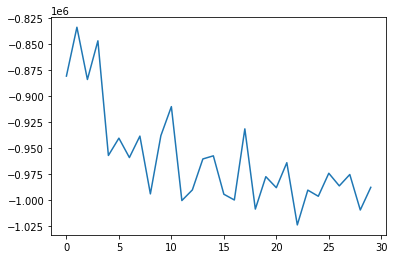

In [209]:
plt.plot(VAE_losses)

In [210]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.cuda()
        reconstruction,_,_ = model(test_examples)
        break

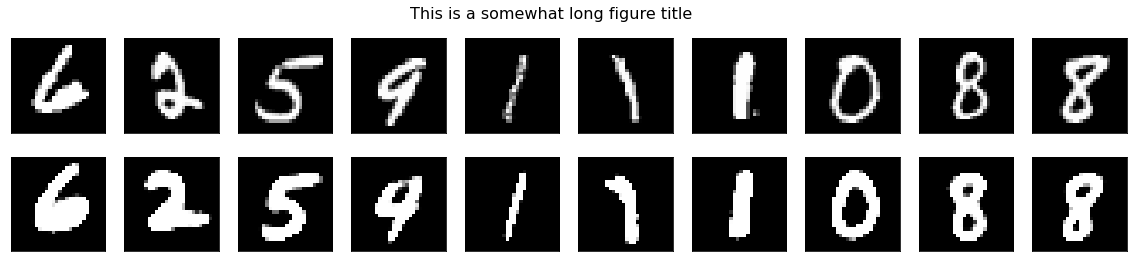

In [218]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    plt.suptitle('Original Images', fontsize=16)
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples.cpu()[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle('Reconstructed Images', fontsize=16)
    for index in range(number):
        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction.cpu()[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

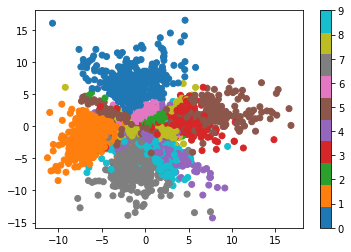

In [213]:
def plot_latent(model, data, num_batches = 100):
  for i, (img, labels) in enumerate(data):
    img = Variable(img).cuda()
    h = model.encoder(img)
    latent_space= model.fc1(h)
    #latent_space, _ = model.encode(img)
    latent_space = latent_space.reshape([64,-1,2])
    latent_space = latent_space.to('cpu').detach().numpy()
    plt.scatter(latent_space[:,:, 0], latent_space[:,:, 1], c=labels.to('cpu').detach().numpy(),  cmap='tab10')
    if i > num_batches:
      plt.colorbar()
      break
plot_latent(model, test_loader)

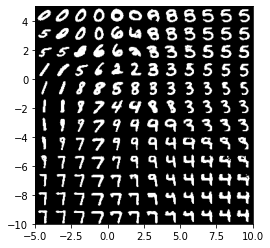

In [216]:
def plot_reconstructed(model, r0=(-5, 10), r1=(-10, 5), n=12):
  w = 28
  img = np.zeros((n*w, n*w))
  for i, y in enumerate(np.linspace(*r1, n)):
      for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.Tensor([[x, y]]).cuda()
        #print(z)
        x_hat = model.decoder(z)
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
  plt.imshow(img, extent=[*r0, *r1])
plot_reconstructed(model)